<a href="https://colab.research.google.com/github/FerminT/NeuromatchAcademy/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)



In [ ]:
#@title Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
#@title Data loading
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

number_of_neurons = dat['sresp'][:, 0].shape[0]
number_of_trials  = dat['sresp'][0, :].shape[0]
print('#Neurons recorded in V1 cortex: ' + str(number_of_neurons))
print('#Stimuli presented to mouse: ' + str(number_of_trials))

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])
#Neurons recorded in V1 cortex: 23589
#Stimuli presented to mouse: 4598


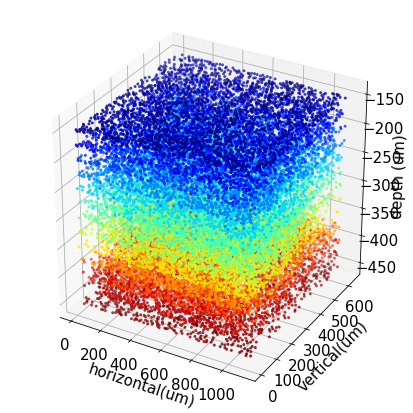

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1],z[::-1], 'o', s = 4, c = cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel = 'vertical(um)', zlabel='depth (um)');

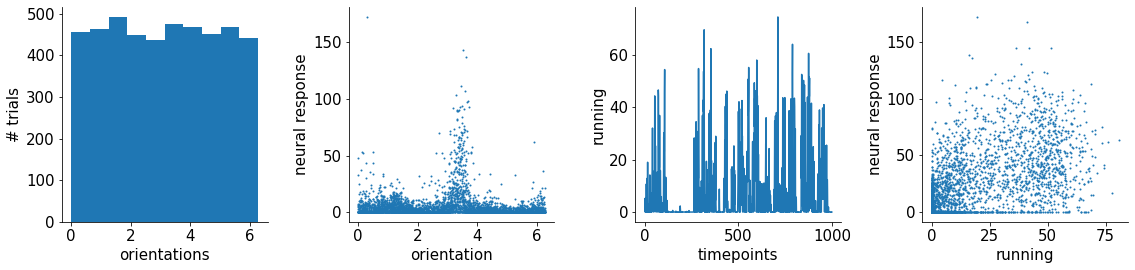

In [ ]:
#@title Basic data properties using plot, hist and scatter
ax = plt.subplot(1,5,1)
plt.hist(dat['istim'])
ax.set(xlabel='orientations', ylabel = '# trials')

ax = plt.subplot(1,5,2)
plt.scatter(dat['istim'], dat['sresp'][1000], s= 1)
ax.set(xlabel = 'orientation', ylabel = 'neural response')

ax = plt.subplot(1,5,3)
plt.plot(dat['run'][:1000])
ax.set(xlabel = 'timepoints', ylabel = 'running')

ax = plt.subplot(1,5,4)
plt.scatter(dat['run'], dat['sresp'][20998], s= 1)
ax.set(xlabel = 'running', ylabel = 'neural response')

plt.show()

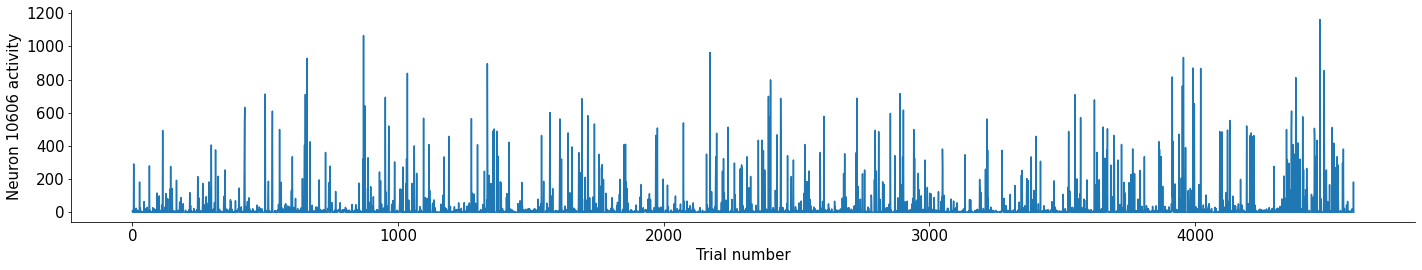

In [ ]:
#@title Plot speed across trials
rand = np.random.randint(low=0, high=len(dat['sresp'][:]) - 1)
plt.xlabel('Trial number')
plt.ylabel('Neuron ' + str(rand) + ' activity')
plt.plot(dat['sresp'][rand])

Running mean: 12.220465 STD: 18.692202 Median: 0.5002701
Min. speed: 0.0 Max. speed: 80.61597
Percentil 25: 0.0
Percentil 40: 0.05941468030214316
Percentil 50: 0.5002701431512833
Percentil 60: 4.526822090148925
Percentil 70: 11.864273071289059
Percentil 80: 28.4854965209961


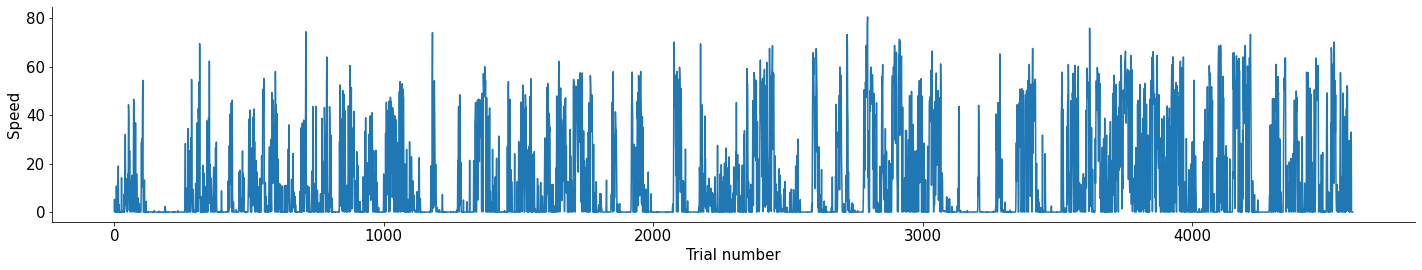

In [ ]:
#@title Analyze speed distribution
plt.xlabel('Trial number')
plt.ylabel('Speed')
plt.plot(dat['run'])
running_mean = np.mean(dat['run'])
running_std  = np.std(dat['run'])
running_median = np.median(dat['run'])
percentiles = [25, 40, 50, 60, 70, 80]
running_min  = np.min(dat['run'])
running_max  = np.max(dat['run'])
print('Running mean: ' + str(running_mean) + ' STD: ' + str(running_std) + ' Median: ' + str(running_median))
print('Min. speed: ' + str(running_min) + ' Max. speed: ' + str(running_max))
for perc in percentiles:
  print('Percentil ' + str(perc) + ': ' + str(np.percentile(dat['run'], perc)))

In [ ]:
#@title Divide the dataset in stationary and running groups
dataset = dat["sresp"]
vel = dat["run"]
maskrun  = [vel >= 2]
maskstat = [vel < 2]
# Esto ocupa bastante memoria! Borrar si hace falta!
run_sresp  = dataset[:,maskrun[0]]
stat_sresp = dataset[:,maskstat[0]]
print('There are ' + str(run_sresp.shape[1]) + ' trials while running')
print('There are ' + str(stat_sresp.shape[1]) + ' trials while remaining still')

There are 2053 trials while running
There are 2545 trials while remaining still


In [ ]:
#@title Add 'locomot' feature
dat['locomot'] = np.where(dat['run'] < 2, 0, 1)

run_istim  = dat['istim'][dat['locomot'] == 1]
stat_istim = dat['istim'][dat['locomot'] == 0]

assert dat['locomot'][dat['locomot'] == 1].shape == run_istim.shape
assert dat['locomot'][dat['locomot'] == 0].shape == stat_istim.shape
assert run_sresp[0, :].shape  == run_istim.shape
assert stat_sresp[0, :].shape == stat_istim.shape

In [ ]:
#@title Split the data for running group
from sklearn.model_selection import train_test_split
# Generate train and test data for running group
run_sresp_train, run_sresp_test, run_istim_train, run_istim_test = \
  train_test_split(run_sresp.T, run_istim, test_size=0.2, random_state=42)

# From the training split, get 10% as validation data
run_sresp_train, run_sresp_valid, run_istim_train, run_istim_valid = \
  train_test_split(run_sresp_train, run_istim_train, test_size=0.125, random_state=42)

print(run_sresp_train.shape)
print(run_sresp_valid.shape)
print(run_sresp_test.shape)

(1436, 23589)
(206, 23589)
(411, 23589)


In [ ]:
#@title Split the data for stationary group
# Generate train and test data for stationary group
stat_sresp_train, stat_sresp_test, stat_istim_train, stat_istim_test = \
  train_test_split(stat_sresp.T, stat_istim, test_size=0.2, random_state=42)

# From the training split, get 10% as validation data
stat_sresp_train, stat_sresp_valid, stat_istim_train, stat_istim_valid = \
  train_test_split(stat_sresp_train, stat_istim_train, test_size=0.125, random_state=42)

print(stat_sresp_train.shape)
print(stat_sresp_valid.shape)
print(stat_sresp_test.shape)

(1781, 23589)
(255, 23589)
(509, 23589)


In [ ]:
#@title Linear Regressions for running and stationary splits
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr_run  = LinearRegression().fit(run_sresp_train, run_istim_train)
lr_stat = LinearRegression().fit(stat_sresp_train, stat_istim_train)

In [ ]:
#@title Test the linear models on their corresponding testing splits
predicted_istim_run  = lr_run.predict(run_sresp_test)
predicted_istim_stat = lr_stat.predict(stat_sresp_test)

print("rMSE (running split) on running lr: " + str(mean_squared_error(run_istim_test, predicted_istim_run, squared=False)))
print("rMSE (stationary split) on stationary lr: " + str(mean_squared_error(stat_istim_test, predicted_istim_stat, squared=False)))

rMSE (running split) on running lr: 0.7574030605002078
rMSE (stationary split) on stationary lr: 0.7834376214009695


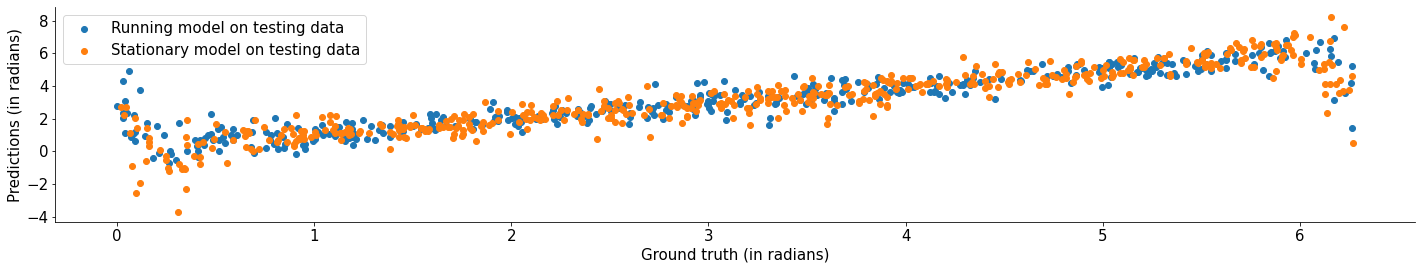

In [ ]:
#@title Plot the linear models on their corresponding testing splits
plt.xlabel('Ground truth (in radians)')
plt.ylabel('Predictions (in radians)')
plt.scatter(run_istim_test, predicted_istim_run, label='Running model on testing data')
plt.scatter(stat_istim_test, predicted_istim_stat, label='Stationary model on testing data')
plt.legend()

In [ ]:
#@title Test the linear models on the opposite testing splits
predicted_istim_run  = lr_run.predict(stat_sresp_test)
predicted_istim_stat = lr_stat.predict(run_sresp_test)

print("rMSE (stationary split) on running lr: " + str(mean_squared_error(stat_istim_test, predicted_istim_run, squared=False)))
print("rMSE (running split) on stationary lr: " + str(mean_squared_error(run_istim_test, predicted_istim_stat, squared=False)))

rMSE (stationary split) on running lr: 0.8751447273971446
rMSE (running split) on stationary lr: 1.0239954921712342


The stark difference in performance shows the data distributions are not the same


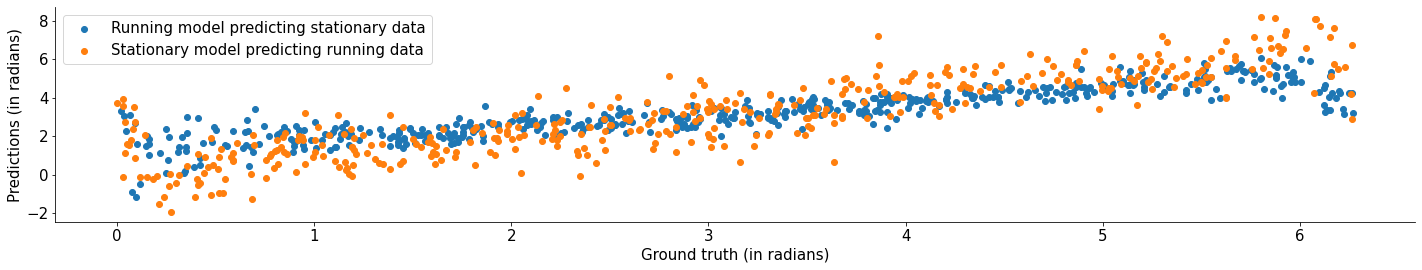

In [ ]:
#@title Plot linear models on the opposite testing splits
plt.xlabel('Ground truth (in radians)')
plt.ylabel('Predictions (in radians)')
plt.scatter(stat_istim_test, predicted_istim_run, label='Running model predicting stationary data')
plt.scatter(run_istim_test, predicted_istim_stat, label='Stationary model predicting running data')
plt.legend()
print("The stark difference in performance shows the data distributions are not the same")

In [ ]:
#@title Set constants
device = 'cpu'
batch_size = 64
seed = 2021
g_seed = torch.Generator()
g_seed.manual_seed(seed)
number_of_features = 1024

In [ ]:
#@title Define the MLP model
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(number_of_features, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 1)
    self.dropout1 = nn.Dropout(p=0.3)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout1(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    x = F.relu(x)
    x = self.fc5(x)
    output = torch.tanh(x)

    return output

In [ ]:
#@title Split the data for running and stationary group
from sklearn.model_selection import train_test_split
# Generate train and test data for running group
run_sresp_train, run_sresp_test, run_istim_train, run_istim_test = \
  train_test_split(run_sresp.T, run_istim, test_size=0.2, random_state=42)

# From the training split, get 10% as validation data
run_sresp_train, run_sresp_valid, run_istim_train, run_istim_valid = \
  train_test_split(run_sresp_train, run_istim_train, test_size=0.125, random_state=42)

print(run_sresp_train.shape)
print(run_sresp_valid.shape)
print(run_sresp_test.shape)

# Generate train and test data for stationary group
stat_sresp_train, stat_sresp_test, stat_istim_train, stat_istim_test = \
  train_test_split(stat_sresp.T, stat_istim, test_size=0.2, random_state=42)

# From the training split, get 10% as validation data
stat_sresp_train, stat_sresp_valid, stat_istim_train, stat_istim_valid = \
  train_test_split(stat_sresp_train, stat_istim_train, test_size=0.125, random_state=42)

print(stat_sresp_train.shape)
print(stat_sresp_valid.shape)
print(stat_sresp_test.shape)

(1436, 23589)
(206, 23589)
(411, 23589)
(1781, 23589)
(255, 23589)
(509, 23589)


In [ ]:
#@title Prepare the training data
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# Normalize the data
run_istim_train  = (run_istim_train - np.pi) / np.pi
stat_istim_train = (stat_istim_train - np.pi) / np.pi

assert np.max(run_istim_train) <= 1
assert np.min(run_istim_train) >= -1
assert np.max(stat_istim_train) <= 1
assert np.min(stat_istim_train) >= -1

indices = np.random.choice(number_of_neurons, size=number_of_features)
run_sresp_train_  = run_sresp_train[:, indices]
stat_sresp_train_ = stat_sresp_train[:, indices]

run_train_data  = TensorDataset(torch.Tensor(run_sresp_train_).to(device), torch.Tensor(run_istim_train).to(device))
stat_train_data = TensorDataset(torch.Tensor(stat_sresp_train_).to(device), torch.Tensor(stat_istim_train).to(device))

run_train_loader = DataLoader(run_train_data,
                           batch_size=batch_size,
                           shuffle=True,
                           worker_init_fn=seed_worker,
                           generator=g_seed,
                           )

stat_train_loader = DataLoader(stat_train_data,
                           batch_size=batch_size,
                           shuffle=True,
                           worker_init_fn=seed_worker,
                           generator=g_seed,
                           )

In [ ]:
#@title Prepare testing data
run_istim_valid  = (run_istim_valid - np.pi) / np.pi
stat_istim_valid = (stat_istim_valid - np.pi) / np.pi
run_istim_test  = (run_istim_test - np.pi) / np.pi
stat_istim_test = (stat_istim_test - np.pi) / np.pi

assert np.max(run_istim_valid) <= 1
assert np.min(run_istim_valid) >= -1
assert np.max(stat_istim_valid) <= 1
assert np.min(stat_istim_valid) >= -1

# Use same indices as before, so we pick the same neurons
run_sresp_test_  = run_sresp_test[:, indices]
stat_sresp_test_ = stat_sresp_test[:, indices]
run_sresp_valid_  = run_sresp_valid[:, indices]
stat_sresp_valid_ = stat_sresp_valid[:, indices]

run_valid_data  = TensorDataset(torch.Tensor(run_sresp_valid_).to(device), torch.Tensor(run_istim_valid).to(device))
stat_valid_data = TensorDataset(torch.Tensor(stat_sresp_valid_).to(device), torch.Tensor(stat_istim_valid).to(device))

run_test_data  = TensorDataset(torch.Tensor(run_sresp_test_).to(device), torch.Tensor(run_istim_test).to(device))
stat_test_data = TensorDataset(torch.Tensor(stat_sresp_test_).to(device), torch.Tensor(stat_istim_test).to(device))

run_valid_loader = DataLoader(run_valid_data, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                         )

run_test_loader = DataLoader(run_test_data, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                         )

stat_valid_loader = DataLoader(stat_valid_data, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                         )

stat_test_loader = DataLoader(stat_test_data, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                         )

In [ ]:
#@title Define training method
from sklearn.metrics import mean_squared_error

def train(model, train_loader, optimizer, device, criterion=nn.MSELoss):
  model.to(device)
  model.train()
  loss = 0
  rMSE = 0
  for data in train_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).float()

    optimizer.zero_grad()
    outputs = model(inputs).squeeze()

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
      radians_output = outputs * np.pi + np.pi
      radians_labels = labels * np.pi + np.pi
    rMSE += mean_squared_error(radians_labels, radians_output, squared=False)
    loss += loss.item()

  loss /= len(train_loader)
  rMSE /= len(train_loader)
  return loss, rMSE

In [ ]:
#@title Define test method
def test(model, test_loader, criterion=nn.MSELoss(), device='cpu'):
  model.to(device)
  model.eval()
  test_loss = 0
  predictions = []
  rMSE = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data).squeeze()
      predictions.append(output.tolist())
      current_loss = criterion(output, target).item()
      test_loss += current_loss

      radians_output = output * np.pi + np.pi
      radians_target = target * np.pi + np.pi
      rMSE += mean_squared_error(radians_target, radians_output, squared=False)

  rMSE /= len(test_loader)
  test_loss /= len(test_loader)
  return test_loss, predictions, rMSE

In [ ]:
#@title Train running model 
run_model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(run_model.parameters(), lr=5e-4)
num_epochs = 100

training_losses   = []
validation_losses = []
training_rMSE   = []
validation_rMSE = []
run_validation_predictions = []
for epoch in tqdm(range(num_epochs)):
  train_epoch_loss, train_epoch_rMSE = train(run_model, run_train_loader, optimizer, device, criterion)
  validation_epoch_loss, run_validation_predictions, validation_epoch_rMSE = test(run_model, run_valid_loader, criterion, device)
  training_losses.append(train_epoch_loss)
  training_rMSE.append(train_epoch_rMSE)
  validation_losses.append(validation_epoch_loss)
  validation_rMSE.append(validation_epoch_rMSE)

  0%|          | 0/100 [00:00<?, ?it/s]

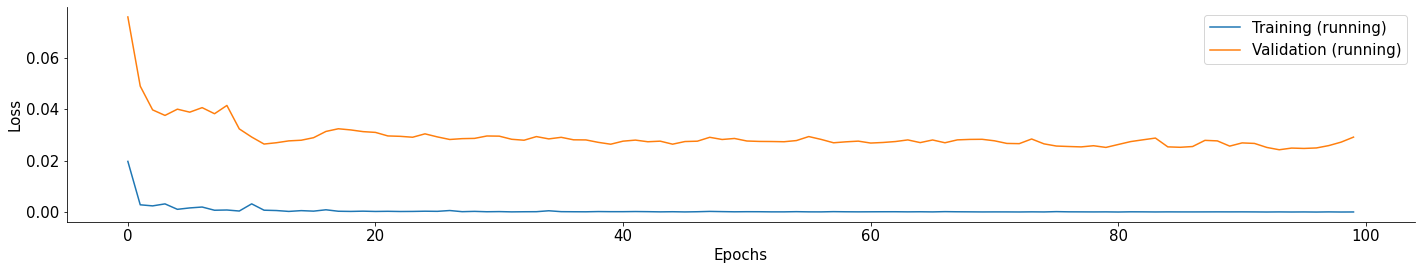

Training loss: tensor(7.3745e-05, grad_fn=<DivBackward0>)
Validation loss: 0.029175901552662253


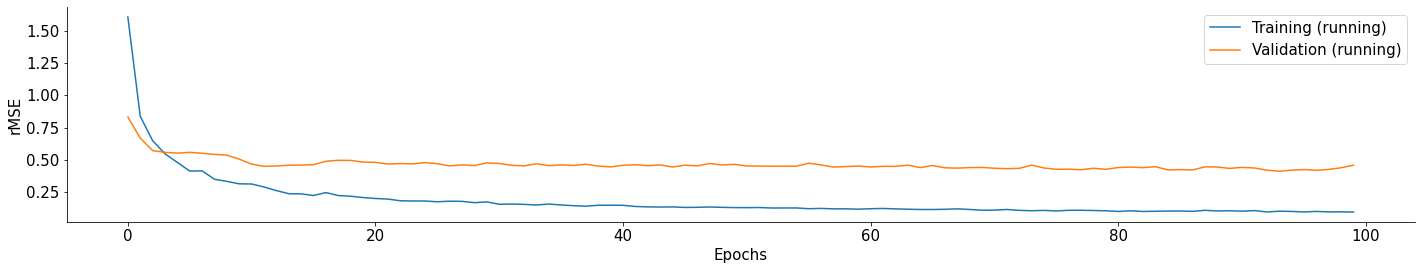

Training rMSE: 0.09658069714255955
Validation rMSE: 0.4594682827591896


In [ ]:
#@title Plot loss and rMSE through epochs in training for running model
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(num_epochs), training_losses, label='Training (running)')
plt.plot(range(num_epochs), validation_losses, label='Validation (running)')
plt.legend()
plt.show()
print('Training loss: ' + str(training_losses[-1]))
print('Validation loss: ' + str(validation_losses[-1]))
plt.xlabel('Epochs')
plt.ylabel('rMSE')
plt.plot(range(num_epochs), training_rMSE, label='Training (running)')
plt.plot(range(num_epochs), validation_rMSE, label='Validation (running)')
plt.legend()
plt.show()
print('Training rMSE: ' + str(training_rMSE[-1]))
print('Validation rMSE: ' + str(validation_rMSE[-1]))

In [ ]:
#@title Train stationary model
stat_model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(stat_model.parameters(), lr=5e-4)

training_losses   = []
validation_losses = []
training_rMSE   = []
validation_rMSE = []
stat_validation_predictions = []
for epoch in tqdm(range(num_epochs)):
  train_epoch_loss, train_epoch_rMSE = train(stat_model, stat_train_loader, optimizer, device, criterion)
  validation_epoch_loss, stat_validation_predictions, validation_epoch_rMSE = test(stat_model, stat_valid_loader, criterion, device)
  training_losses.append(train_epoch_loss)
  training_rMSE.append(train_epoch_rMSE)
  validation_losses.append(validation_epoch_loss)
  validation_rMSE.append(validation_epoch_rMSE)

  0%|          | 0/100 [00:00<?, ?it/s]

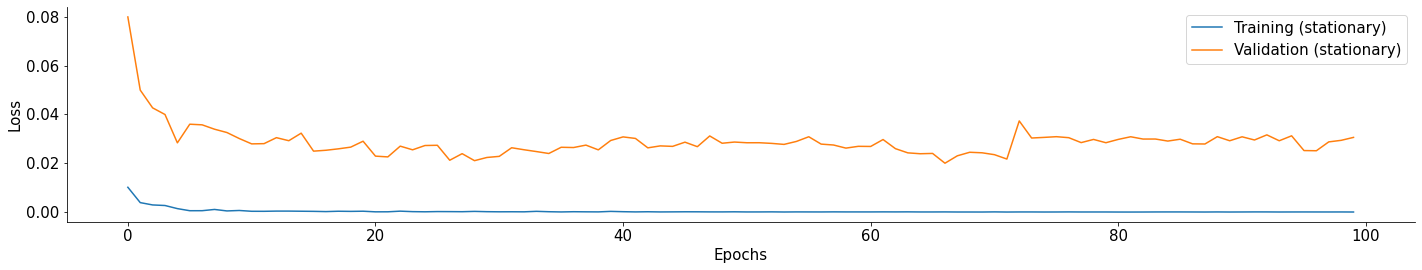

Training loss: tensor(5.6743e-05, grad_fn=<DivBackward0>)
Validation loss: 0.0306134563870728


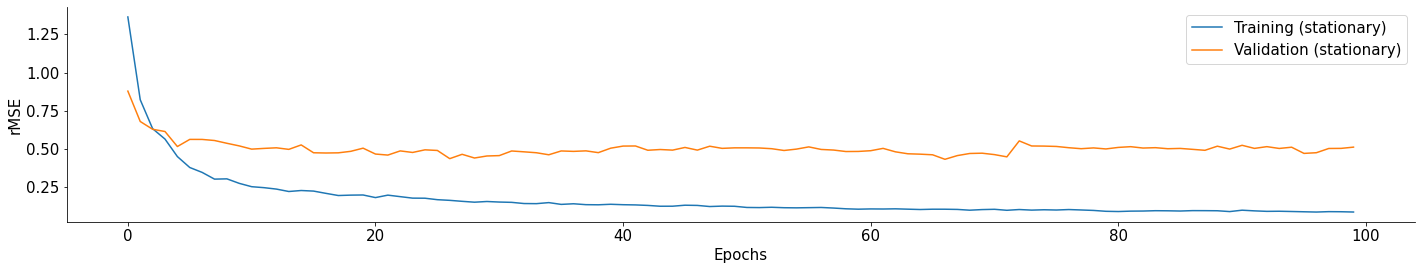

Training rMSE: 0.08987017375017915
Validation rMSE: 0.5134955123066902


In [ ]:
#@title Plot loss and rMSE through epochs in training for stationary model
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(num_epochs), training_losses, label='Training (stationary)')
plt.plot(range(num_epochs), validation_losses, label='Validation (stationary)')
plt.legend()
plt.show()
print('Training loss: ' + str(training_losses[-1]))
print('Validation loss: ' + str(validation_losses[-1]))
plt.xlabel('Epochs')
plt.ylabel('rMSE')
plt.plot(range(num_epochs), training_rMSE, label='Training (stationary)')
plt.plot(range(num_epochs), validation_rMSE, label='Validation (stationary)')
plt.legend()
plt.show()
print('Training rMSE: ' + str(training_rMSE[-1]))
print('Validation rMSE: ' + str(validation_rMSE[-1]))

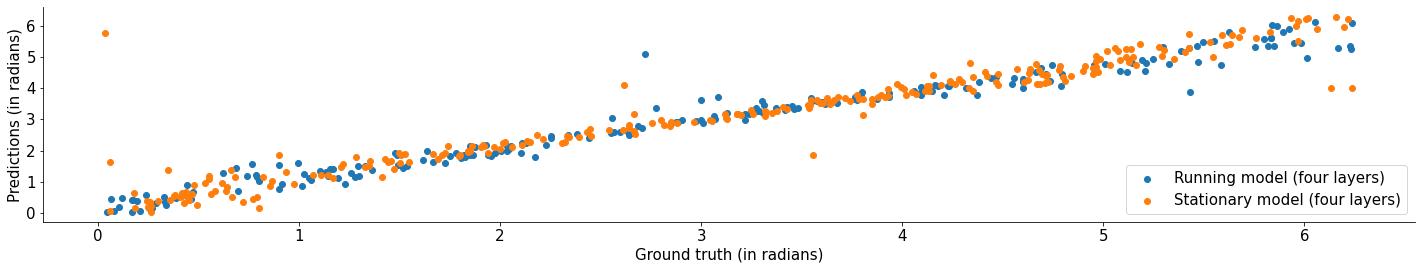

In [ ]:
#@title Plot validation predictions
plt.xlabel('Ground truth (in radians)')
plt.ylabel('Predictions (in radians)')
ground_truth_run = run_istim_valid * np.pi + np.pi
predictions_run  = np.array([item for sublist in run_validation_predictions for item in sublist])
predictions_run  = predictions_run * np.pi + np.pi

ground_truth_stat = stat_istim_valid * np.pi + np.pi
predictions_stat  = np.array([item for sublist in stat_validation_predictions for item in sublist])
predictions_stat  = predictions_stat * np.pi + np.pi

plt.scatter(ground_truth_run, predictions_run, label='Running model (four layers)')
plt.scatter(ground_truth_stat, predictions_stat, label='Stationary model (four layers)')
plt.legend()
plt.show()

In [ ]:
#@title Test the models
_, stat_test_predictions, _ = test(stat_model, stat_test_loader, criterion, device)
_, run_test_predictions, _ = test(run_model, run_test_loader, criterion, device)

In [ ]:
#@title Post process data
run_predictions  = np.array([item for sublist in run_test_predictions for item in sublist])
run_predictions  = run_predictions * np.pi + np.pi
run_ground_truth = run_istim_test * np.pi + np.pi
stat_predictions  = np.array([item for sublist in stat_test_predictions for item in sublist])
stat_predictions  = stat_predictions * np.pi + np.pi
stat_ground_truth = stat_istim_test * np.pi + np.pi

rMSE for stationary model on testing data: 0.5432999711091125
rMSE for running model on testing data: 0.6268552979008946


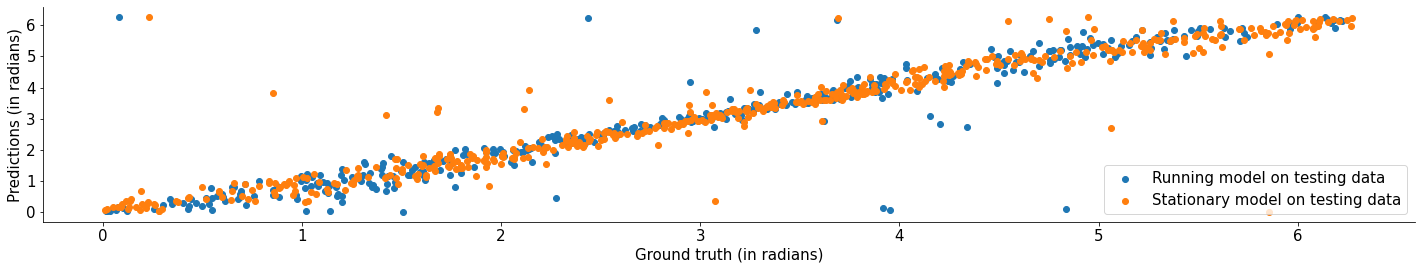

In [ ]:
#@title Plot testing predictions
plt.xlabel('Ground truth (in radians)')
plt.ylabel('Predictions (in radians)')
plt.scatter(run_predictions, run_ground_truth, label='Running model on testing data')
plt.scatter(stat_predictions, stat_ground_truth, label='Stationary model on testing data')
plt.legend()
print('rMSE for stationary model on testing data: ' + str(mean_squared_error(stat_ground_truth, stat_predictions, squared=False)))
print('rMSE for running model on testing data: ' + str(mean_squared_error(run_ground_truth, run_predictions, squared=False)))

In [ ]:
#@title Interchange testing data
_, stat_test_predictions, _ = test(stat_model, run_test_loader, criterion)
_, run_test_predictions, _  = test(run_model, stat_test_loader, criterion)

In [ ]:
#@title Post process data
run_predictions  = np.array([item for sublist in run_test_predictions for item in sublist])
run_predictions  = run_predictions * np.pi + np.pi
run_ground_truth = stat_istim_test * np.pi + np.pi
stat_predictions  = np.array([item for sublist in stat_test_predictions for item in sublist])
stat_predictions  = stat_predictions * np.pi + np.pi
stat_ground_truth = run_istim_test * np.pi + np.pi

rMSE for running model on testing data: 0.8738622758545357
rMSE for stationary model on testing data: 0.7909946048562929


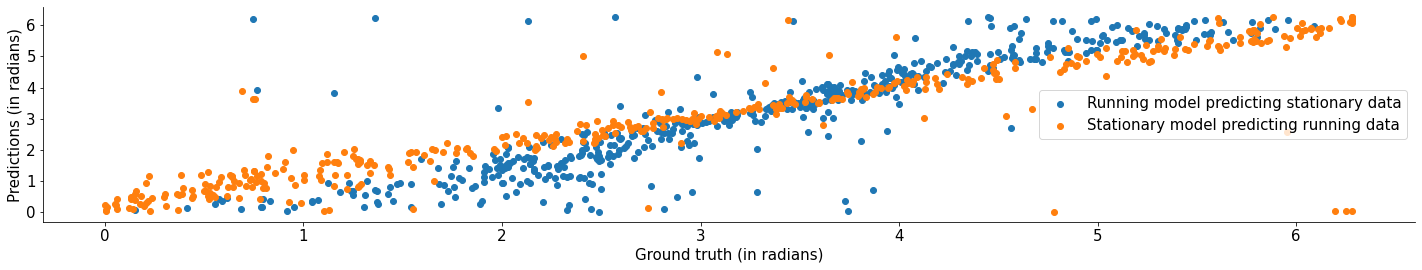

In [ ]:
#@title Plot testing predictions switching the data: running on stationary and viceversa
plt.xlabel('Ground truth (in radians)')
plt.ylabel('Predictions (in radians)')
plt.scatter(run_predictions, run_ground_truth, label='Running model predicting stationary data')
print('rMSE for running model on testing data: ' + str(mean_squared_error(run_ground_truth, run_predictions, squared=False)))
plt.scatter(stat_predictions, stat_ground_truth, label='Stationary model predicting running data')
plt.legend()
print('rMSE for stationary model on testing data: ' + str(mean_squared_error(stat_ground_truth, stat_predictions, squared=False)))

In [ ]:
#@title Method to train model on a given learning rate
def run_model_on_learning_rate(learning_rate):
  run_model = MLP()
  criterion = nn.MSELoss()
  optimizer = optim.Adam(run_model.parameters(), lr=learning_rate)
  num_epochs = 1000

  run_model.to(device)
  run_model.train()
  training_losses = []
  for epoch in tqdm(range(num_epochs + 1)):  # loop over the dataset multiple times
    for data in run_train_loader:
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).float()

      # zero the parameter gradients
      optimizer.zero_grad()
      outputs = run_model(inputs).squeeze()

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      training_losses += [loss.item()]
    if epoch % 100 == 0:
      print('Training loss for lr ' + str(learning_rate) + ' in epoch ' + str(epoch) + ': ' + str(training_losses[-1]))

  print(np.mean(np.array(training_losses)))
  return training_losses

In [ ]:
#@title Looking for learning rates
training_losses_for_lr = []
learning_rates = [5e-3, 5e-4, 1e-3, 1e-2, 1e-4, 1e-1]
for lr in learning_rates:
  training_losses_for_lr += run_model_on_learning_rate(lr)

Training loss for lr 0.005 in epoch 0: 0.03385496512055397
Training loss for lr 0.005 in epoch 100: 0.03104158118367195
Training loss for lr 0.005 in epoch 200: 0.03516586869955063
Training loss for lr 0.005 in epoch 300: 0.03527187928557396
Training loss for lr 0.005 in epoch 400: 0.036712419241666794
Training loss for lr 0.005 in epoch 500: 0.03873066604137421
Training loss for lr 0.005 in epoch 600: 0.03822992369532585
Training loss for lr 0.005 in epoch 700: 0.03540434315800667
Training loss for lr 0.005 in epoch 800: 0.034457430243492126
Training loss for lr 0.005 in epoch 900: 0.033358849585056305



Training loss for lr 0.0005 in epoch 0: 0.03481656312942505
Training loss for lr 0.0005 in epoch 100: 0.03865650296211243
Training loss for lr 0.0005 in epoch 200: 0.025692015886306763
Training loss for lr 0.0005 in epoch 300: 0.03711684048175812
Training loss for lr 0.0005 in epoch 400: 0.026422511786222458
Training loss for lr 0.0005 in epoch 500: 0.0224735327064991
Training loss for lr 0.0005 in epoch 600: 0.045989181846380234
Training loss for lr 0.0005 in epoch 700: 0.01586310938000679
Training loss for lr 0.0005 in epoch 800: 0.01363955158740282
Training loss for lr 0.0005 in epoch 900: 0.011629214510321617



Training loss for lr 0.001 in epoch 0: 0.029636554419994354
Training loss for lr 0.001 in epoch 100: 0.031117452308535576
Training loss for lr 0.001 in epoch 200: 0.027720414102077484
Training loss for lr 0.001 in epoch 300: 0.035649996250867844
Training loss for lr 0.001 in epoch 400: 0.025340847671031952
Training loss for lr 0.001 in epoch 500: 0.017991993576288223
Training loss for lr 0.001 in epoch 600: 0.013532567769289017
Training loss for lr 0.001 in epoch 700: 0.021024685353040695
Training loss for lr 0.001 in epoch 800: 0.015810828655958176
Training loss for lr 0.001 in epoch 900: 0.016837066039443016



Training loss for lr 0.01 in epoch 0: 0.03541269898414612
Training loss for lr 0.01 in epoch 100: 0.03649754449725151
Training loss for lr 0.01 in epoch 200: 0.03686738759279251
Training loss for lr 0.01 in epoch 300: 0.033181075006723404
Training loss for lr 0.01 in epoch 400: 0.03356356918811798
Training loss for lr 0.01 in epoch 500: 0.034269507974386215
Training loss for lr 0.01 in epoch 600: 0.041822612285614014
Training loss for lr 0.01 in epoch 700: 0.03442767634987831
Training loss for lr 0.01 in epoch 800: 0.031120341271162033
Training loss for lr 0.01 in epoch 900: 0.03598758950829506



Training loss for lr 0.0001 in epoch 0: 0.9060050249099731
Training loss for lr 0.0001 in epoch 100: 0.03423183411359787
Training loss for lr 0.0001 in epoch 200: 0.0372135266661644
Training loss for lr 0.0001 in epoch 300: 0.03782598301768303
Training loss for lr 0.0001 in epoch 400: 0.03354137763381004
Training loss for lr 0.0001 in epoch 500: 0.03351977840065956
Training loss for lr 0.0001 in epoch 600: 0.022317612543702126
Training loss for lr 0.0001 in epoch 700: 0.026633869856595993
Training loss for lr 0.0001 in epoch 800: 0.026591898873448372
Training loss for lr 0.0001 in epoch 900: 0.02666248008608818



Training loss for lr 0.1 in epoch 0: 0.03707167133688927
Training loss for lr 0.1 in epoch 100: 0.037083324044942856
Training loss for lr 0.1 in epoch 200: 0.03289705514907837
Training loss for lr 0.1 in epoch 300: 0.03182777017354965
Training loss for lr 0.1 in epoch 400: 0.036410149186849594
Training loss for lr 0.1 in epoch 500: 0.030071338638663292
Training loss for lr 0.1 in epoch 600: 0.03165452182292938
Training loss for lr 0.1 in epoch 700: 0.03316012769937515
Training loss for lr 0.1 in epoch 800: 0.037242572754621506
Training loss for lr 0.1 in epoch 900: 0.032845232635736465



In [ ]:
#@title Define classification model parameters
device = 'cpu'
number_of_features = 512
batch_size = 64
seed = 2021
g_seed = torch.Generator()
g_seed.manual_seed(seed)

In [ ]:
#@title Split the data for classifier 
from sklearn.model_selection import train_test_split
sresp = dat['sresp']
locomot = dat['locomot']

# Generate train and test data for running group
sresp_train, sresp_test, locomot_train, locomot_test = \
  train_test_split(sresp.T, locomot, test_size=0.2, random_state=42)

# From the training split, get 10% as validation data
sresp_train, sresp_valid, locomot_train, locomot_valid = \
  train_test_split(sresp_train, locomot_train, test_size=0.125, random_state=42)

print(sresp_train.shape)
print(sresp_valid.shape)
print(locomot_test.shape)

(3218, 23589)
(460, 23589)
(920,)


In [ ]:
#@title Define the classification model: if the mouse is running or not given its neural activity
class ClassificationModel(nn.Module):
  def __init__(self):
    super(ClassificationModel, self).__init__()
    self.fc1 = nn.Linear(number_of_features, 128)
    # self.fc2 = nn.Linear(512, 256)
    # self.fc2 = nn.Linear(256, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 1)
    self.dropout1 = nn.Dropout(p=0.8)
    self.dropout2 = nn.Dropout(p=0.5)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout1(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc3(x)
    # x = F.relu(x)
    # x = self.fc4(x)
    # x = F.relu(x)
    # x = self.fc5(x)
    output = torch.sigmoid(x)

    return output

In [ ]:
#@title Prepare the data
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

indices = np.random.choice(number_of_neurons, size=number_of_features)
sresp_train_ = sresp_train[:, indices]

train_data = TensorDataset(torch.Tensor(sresp_train_).to(device), torch.Tensor(locomot_train).to(device))

train_loader = DataLoader(train_data,
                           batch_size=batch_size,
                           shuffle=True,
                           worker_init_fn=seed_worker,
                           generator=g_seed,
                           )

sresp_valid_ = sresp_valid[:, indices]

test_data = TensorDataset(torch.Tensor(sresp_valid_).to(device), torch.Tensor(locomot_valid).to(device))

test_loader = DataLoader(test_data,
                           batch_size=batch_size,
                           shuffle=False,
                           worker_init_fn=seed_worker,
                           generator=g_seed,
                           )

In [ ]:
#@title Define training method for the classifier
def train_classifier(model, train_loader, optimizer, num_epochs, device, criterion):
  model.to(device)
  model.train()
  correct = 0
  loss_epoch = 0
  total = 0
  l2_lambda = 0.1
  for data in train_loader:
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs   = model(inputs).squeeze()
    predicted = [0.0 if o < 0.5 else 1.0 for o in outputs]

    loss = criterion(outputs, labels)
    # # Apply L2 regularization
    # l2_reg = torch.tensor(0.)
    # for param in model.parameters():
    #   l2_reg += torch.norm(param)
    # loss += l2_lambda * l2_reg
    loss.backward()
    optimizer.step()

    total += labels.size(0)
    loss_epoch += loss.item()
    correct += torch.eq(torch.tensor(predicted).to(device), labels).sum().item()

  acc = 100 * correct / total
  loss_epoch /= len(train_loader)
  return acc, loss_epoch

In [ ]:
#@title Define test method for the classifier
def test_classifier(model, test_loader, criterion, device='cpu'):
  model.eval()
  total = 0
  correct = 0
  loss_batch = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data).squeeze()
      predicted = [0.0 if o < 0.5 else 1.0 for o in output]
      current_loss = criterion(output, target).item()

      loss_batch += current_loss
      total += target.size(0)
      correct += torch.eq(torch.tensor(predicted).to(device), target).sum().item()

  acc = 100 * correct / total
  loss_batch /= len(test_loader)
  return acc, loss_batch

In [ ]:
#@title Train classification model 
classification_model = ClassificationModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(classification_model.parameters(), lr=5e-4)
num_epochs = 10

training_losses = []
training_accuracies = []
testing_losses = []
testing_accuracies = []
for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
  train_acc, train_loss = train_classifier(classification_model, train_loader, optimizer, num_epochs, device, criterion)
  training_losses.append(train_loss)
  training_accuracies.append(train_acc)
  test_acc, test_loss = test_classifier(classification_model, test_loader, criterion, device)
  testing_losses.append(test_loss)
  testing_accuracies.append(test_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

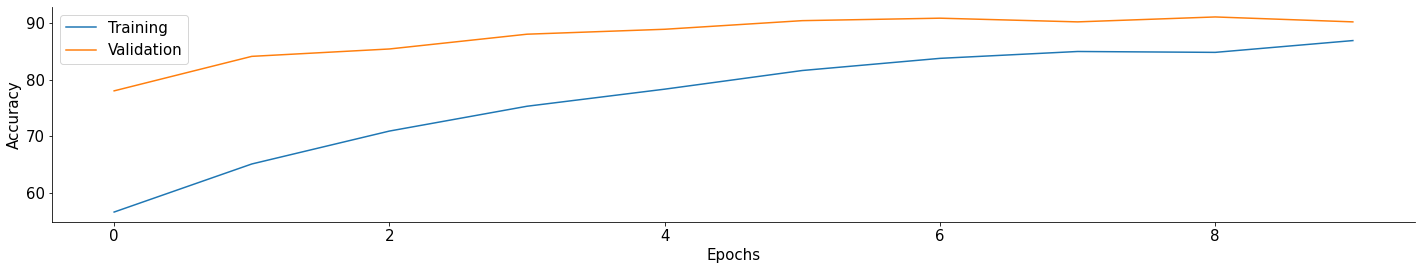

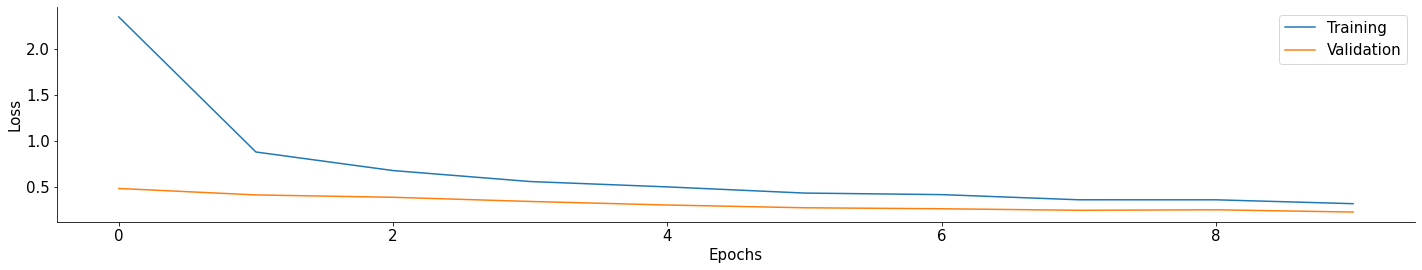

In [ ]:
#@title Plot training accuracy and loss for the classifier
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(range(num_epochs), training_accuracies, label='Training')
plt.plot(range(num_epochs), testing_accuracies, label='Validation')
plt.legend()
plt.show()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(num_epochs), training_losses, label='Training')
plt.plot(range(num_epochs), testing_losses, label='Validation')
plt.legend()
plt.show()

In [ ]:
sresp_test_ = sresp_test[:, indices]

test_data = TensorDataset(torch.Tensor(sresp_test_).to(device), torch.Tensor(locomot_test).to(device))

test_loader = DataLoader(test_data,
                           batch_size=batch_size,
                           shuffle=False,
                           worker_init_fn=seed_worker,
                           generator=g_seed,
                           )

In [ ]:
#@title 90% accuracy for the classifier
acc, loss = test_classifier(classification_model, test_loader, criterion, device)
print('Testing accuracy: ' + str(acc))

Testing accuracy: 89.23913043478261


In [ ]:
#@title Free memory
import gc
del run_sresp
del stat_sresp

gc.collect()

24360

In [ ]:
#@title Divide neurons according to their (x, y, z) coordinates: build 3D cube
cube_width, cube_height, cube_depth = (15, 15, 15)
x_cube = np.repeat([cube_width], number_of_neurons)
y_cube = np.repeat([cube_height], number_of_neurons)
z_cube = np.repeat([cube_depth], number_of_neurons)
cubes = [x_cube, y_cube, z_cube]

pos_from_zero = np.array([dat['xyz'][0, :] - 6, dat['xyz'][1, :] - 6.65, dat['xyz'][2, :] * (-1) - 150])
# Get each neuron's mapped position
mapped_pos = np.array(pos_from_zero // cubes, dtype=int)
num_x, num_y, num_z = np.max(mapped_pos[0, :]), np.max(mapped_pos[1, :]), np.max(mapped_pos[2, :])
print(num_x, num_y, num_z)

74 42 20


In [ ]:
#@title Build 3D cube, where each cell contains the mean activation of all the neurons in that cell
# There'll be a grid for each stimuli, containing the mean activation of all the neurons in each cell of the grid
grid_per_stim = np.zeros(shape=[number_of_trials, num_x + 1, num_y + 1, num_z + 1])
counter       = np.zeros(shape=[number_of_trials, num_x + 1, num_y + 1, num_z + 1])
print(grid_per_stim.shape)

# Initialize grid
cube_size = np.array([cube_width, cube_height, cube_depth])
for neuron in range(number_of_neurons):
  grid_index = 0
  neuron_responses = dat['sresp'][neuron, :]
  for response in neuron_responses:
    neuron_grid_index = mapped_pos.T[neuron]
    grid_per_stim[grid_index, neuron_grid_index[0], neuron_grid_index[1], neuron_grid_index[2]] += response
    if response > 0:
      counter[grid_index, neuron_grid_index[0], neuron_grid_index[1], neuron_grid_index[2]] += 1
    grid_index += 1

grid_per_stim = grid_per_stim / counter

(4598, 75, 43, 21)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
import gc
# Free memory
del counter
gc.collect()

377

In [ ]:
#@title Set constants
device = 'cuda'
batch_size = 64
seed = 2021
g_seed = torch.Generator()
g_seed.manual_seed(seed)

In [ ]:
#@title Code for shuffling the 3D cube: future hypothesis to be tested
# This is done in order to see if the positions actually matter
# z = depth, y = height, x = width
grid_per_stim = np.transpose(grid_per_stim, (0, 3, 2, 1))
grid_per_stim = grid_per_stim[:, :, :, :, np.newaxis]
permuted_grid = grid_per_stim

permuted_z = np.arange(num_z + 1) 
permuted_y = np.arange(num_y + 1) 
permuted_x = np.arange(num_x + 1) 
np.random.shuffle(permuted_z)
np.random.shuffle(permuted_y)
np.random.shuffle(permuted_x)
permuted_grid = permuted_grid[:, permuted_z, :, :, :]
permuted_grid = permuted_grid[:, :, permuted_y, :, :]
permuted_grid = permuted_grid[:, :, :, permuted_x, :]
print(permuted_grid.shape)

(4598, 21, 43, 75, 1)


In [ ]:
#@title Prepare the data
from sklearn.model_selection import train_test_split
# Add channel dimension
# grid_per_stim = np.nan_to_num(grid_per_stim, nan=0.0)
# # z = depth, y = height, x = width
# grid_per_stim = np.transpose(grid_per_stim, (0, 3, 2, 1))
# grid_per_stim = grid_per_stim[:, :, :, :, np.newaxis]

permuted_grid = np.nan_to_num(permuted_grid, nan=0.0)

assert len(grid_per_stim.shape) == 5
assert grid_per_stim.shape[4] == 1
print(grid_per_stim.shape)
# Create training, validation and test splits:
validation_size = .125
testing_size    = .2

istim_data = dat['istim']
# Normalize output
istim_data = (istim_data - np.pi) / np.pi

# sresp_data_train, sresp_data_test, istim_data_train, istim_data_test = \
#   train_test_split(grid_per_stim, istim_data, test_size=testing_size, random_state=42)

sresp_data_train, sresp_data_test, istim_data_train, istim_data_test = \
   train_test_split(permuted_grid, istim_data, test_size=testing_size, random_state=42)

# From the training split, get 12.5% (10% of the original distribution) as validation data
sresp_data_train, sresp_data_valid, istim_data_train, istim_data_valid = \
  train_test_split(sresp_data_train, istim_data_train, test_size=validation_size, random_state=42)


(4598, 21, 43, 75, 1)


In [ ]:
#@title Build DataLoaders
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

train_data = TensorDataset(torch.Tensor(sresp_data_train).to(device), torch.Tensor(istim_data_train).to(device))
valid_data = TensorDataset(torch.Tensor(sresp_data_valid).to(device), torch.Tensor(istim_data_valid).to(device))
test_data  = TensorDataset(torch.Tensor(sresp_data_test).to(device), torch.Tensor(istim_data_test).to(device))

train_loader = DataLoader(train_data,
                           batch_size=batch_size,
                           shuffle=True,
                           worker_init_fn=seed_worker,
                           generator=g_seed,
                           )

valid_loader = DataLoader(valid_data,
                           batch_size=batch_size,
                           shuffle=False,
                           worker_init_fn=seed_worker,
                           generator=g_seed,
                           num_workers=0
                           )

test_loader = DataLoader(test_data,
                           batch_size=batch_size,
                           shuffle=False,
                           worker_init_fn=seed_worker,
                           generator=g_seed,
                           num_workers=0
                           )

In [ ]:
#@title Define 3D CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv_layer1 = self._conv_layer_set(1, 16)
        self.conv_layer2 = self._conv_layer_set(16, 32)
        self.conv_layer3 = self._conv_layer_set(32, 64)
        self.fc1 = nn.Linear(5760, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=0.5)        
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(3, 3, 3), padding=1),
        nn.ReLU(),
        nn.MaxPool3d((2, 2, 2)),
        )
        return conv_layer
    

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.conv_layer3(out)
        # print('conv3: ' + str(out.shape))
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = torch.tanh(out)
        
        return out

In [ ]:
#@title 3D CNN train method for one epoch
def train_CNN(model, train_loader, optimizer, num_epochs, device, criterion):
  model.to(device)
  model.train()
  loss_epoch = 0
  dims = grid_per_stim.shape[1:4]
  for features, labels in train_loader:
    # (64, 1, 41, 31, 16)
    features = features.to(device)
    labels   = labels.to(device)
    features = features.view(features.size(0), 1, dims[0], dims[1], dims[2])

    optimizer.zero_grad()
    outputs = model(features).squeeze()
    loss    = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    loss_epoch += loss.item()
  
  return loss_epoch / len(train_loader)

In [ ]:
#@title 3D CNN test method
def test_CNN(model, test_loader, criterion, device='cuda'):
  model.eval()
  dims = grid_per_stim.shape[1:4]
  loss_batch = 0
  predictions = []
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data = data.view(data.size(0), 1, dims[0], dims[1], dims[2])
      output = model(data).squeeze()
      current_loss = criterion(output, target).item()

      predictions.append(output.tolist())
      loss_batch += current_loss

  loss_batch /= len(test_loader)
  return loss_batch, predictions

In [ ]:
#@title Definition of hyperparameters
num_epochs = 50
cnn_model = CNNModel()
print(cnn_model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-4)

CNNModel(
  (conv_layer1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=5760, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features

In [ ]:
#@title CNN model training
training_losses   = []
validation_losses = []
validation_predictions = []
for epoch in tqdm(range(num_epochs)):
  train_loss = train_CNN(cnn_model, train_loader, optimizer, num_epochs, device, criterion)
  training_losses.append(train_loss)
  valid_loss, validation_predictions = test_CNN(cnn_model, valid_loader, criterion, device)
  validation_losses.append(valid_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

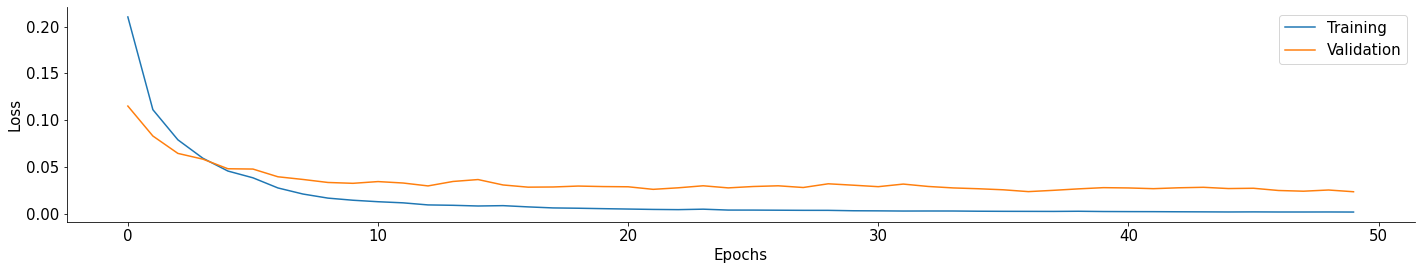

Training loss: 0.001753776856953753
Validation loss: 0.023463081859517843


In [ ]:
#@title Plot loss
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(num_epochs), training_losses, label='Training')
plt.plot(range(num_epochs), validation_losses, label='Validation')
plt.legend()
plt.show()
print('Training loss: ' + str(training_losses[-1]))
print('Validation loss: ' + str(validation_losses[-1]))

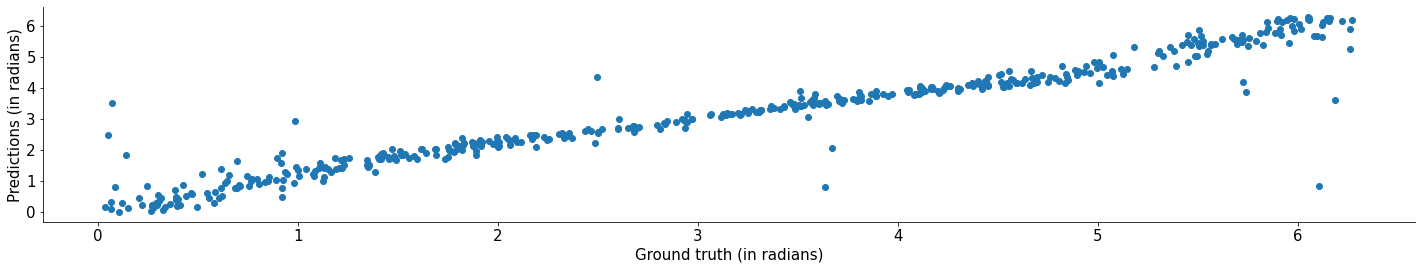

rMSE on validation data: 0.5040967309855763


In [ ]:
#@title Plot 3D CNN validation predictions
from sklearn.metrics import mean_squared_error
predictions = np.array([item for sublist in validation_predictions for item in sublist])
predictions = predictions * np.pi + np.pi
valid_ground_truth = istim_data_valid * np.pi + np.pi
plt.xlabel('Ground truth (in radians)')
plt.ylabel('Predictions (in radians)')
plt.scatter(valid_ground_truth, predictions)
plt.show()
print('rMSE on validation data: ' + str(mean_squared_error(valid_ground_truth, predictions, squared=False)))

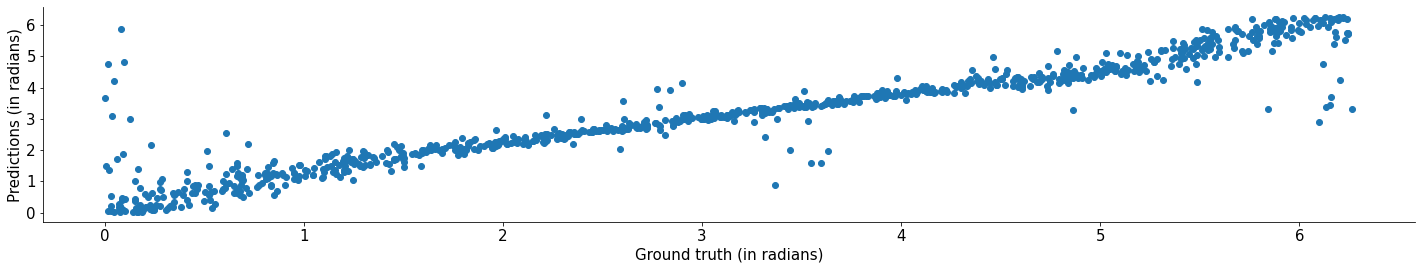

rMSE on testing data: 0.5933156841868981


In [ ]:
#@title Plot 3D CNN testing predictions
criterion = nn.MSELoss()
loss, predictions = test_CNN(cnn_model, test_loader, criterion, device)

predictions  = np.array([item for sublist in predictions for item in sublist])
predictions  = predictions * np.pi + np.pi
ground_truth = istim_data_test * np.pi + np.pi
plt.xlabel('Ground truth (in radians)')
plt.ylabel('Predictions (in radians)')
plt.scatter(ground_truth, predictions)
plt.show()
print('rMSE on testing data: ' + str(mean_squared_error(ground_truth, predictions, squared=False)))